In [1]:
import os
import sys
import glob
import torch
import torchio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine_pirogov as routine
imp.reload(routine)
from utils.routine_pirogov import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

import utils.metrics_deep_mind as metrics_deep_mind
imp.reload(metrics_deep_mind)
from utils.metrics_deep_mind import *

# Making CSV file with all pathes

In [7]:
# subjects = set([x.split('.')[0] for x in os.listdir('../datasets/croped_new_dataset/fcd_brains') if x[:3] == 'fcd'])
# paths_to_all_files = pd.DataFrame(columns = ['Subject', 'T1', 'T2', 'T3', 'fcd_mask'])

# for i, subject in enumerate(subjects):
        
#     path_to_mask = '../datasets/croped_new_dataset/masks/mask_' + subject + '.1.nii.gz'
#     path_to_T1_file = '../datasets/croped_new_dataset/fcd_brains/' + subject + '.1.nii.gz'
#     path_to_T2_file = '../datasets/croped_new_dataset/fcd_brains/' + subject + '.2.nii.gz'
#     path_to_T3_file = '../datasets/croped_new_dataset/fcd_brains/' + subject + '.3.nii.gz'

#     paths_to_all_files.loc[i] = [subject, 
#                                   path_to_T1_file, 
#                                   path_to_T2_file, 
#                                   path_to_T3_file,
#                                   path_to_mask]
    
# paths_to_all_files.to_csv('Pirogov_paths.csv')

In [3]:
paths_to_all_files = pd.read_csv('Pirogov_paths.csv', index_col = 0)

In [4]:
paths_to_all_files.head()

,Subject,T1,T2,T3,fcd_mask
0,fcd_04,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
1,fcd_01,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
2,fcd_23,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
3,fcd_10,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
4,fcd_24,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...


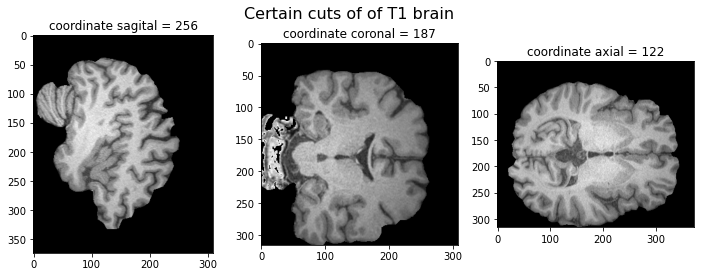

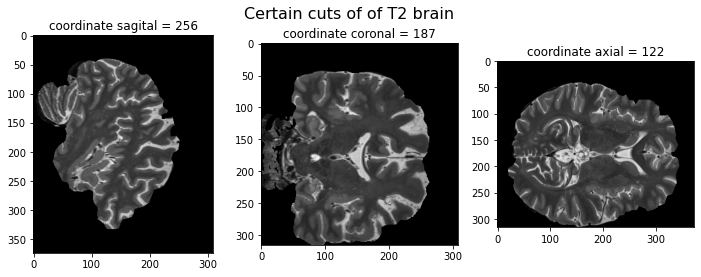

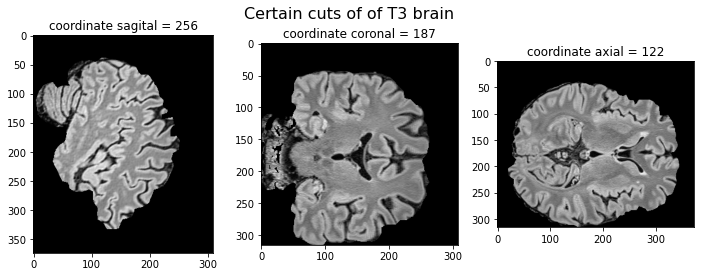

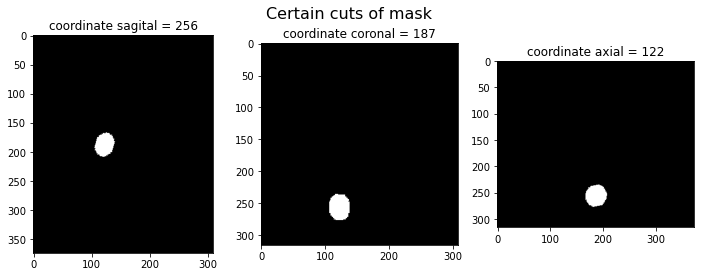

In [10]:
mask = load_nii_to_array(paths_to_all_files.loc[0].fcd_mask)
center_mask = get_center_coord_of_bb(mask)

plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T1), center_mask, 'of T1 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T2), center_mask, 'of T2 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T3), center_mask, 'of T3 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].fcd_mask), center_mask, 'mask')

# Making landmarks

In [11]:
# t1_landmarks_path = 'landmarks/Pirogov_t1_landmarks.npy'
# t2_landmarks_path = 'landmarks/Pirogov_t2_landmarks.npy'
# t3_landmarks_path = 'landmarks/Pirogov_t3_landmarks.npy'

# t1_paths = paths_to_all_files.T1.values.tolist()
# t2_paths = paths_to_all_files.T2.values.tolist()
# t3_paths = paths_to_all_files.T3.values.tolist()
    
# t1_landmarks = (
#     #t1_landmarks_path
#     #if t1_landmarks_path.is_file()
#     #else 
#     HistogramStandardization.train(t1_paths)
# )
# np.save(t1_landmarks_path, t1_landmarks, allow_pickle=True)

# t2_landmarks = (
#     #t2_landmarks_path
#     #if t2_landmarks_path.is_file()
#     #else
#     HistogramStandardization.train(t2_paths)
# )
# np.save(t2_landmarks_path, t2_landmarks, allow_pickle=True)

# t3_landmarks = (
#     #t2_landmarks_path
#     #if t2_landmarks_path.is_file()
#     #else
#     HistogramStandardization.train(t3_paths)
# )
# np.save(t3_landmarks_path, t3_landmarks, allow_pickle=True)

# Making transform

In [5]:
t1_landmarks_path = 'landmarks/Pirogov_t1_landmarks.npy'
t2_landmarks_path = 'landmarks/Pirogov_t2_landmarks.npy'
t3_landmarks_path = 'landmarks/Pirogov_t3_landmarks.npy'

t1_landmark = np.load(t1_landmarks_path)
t2_landmark = np.load(t2_landmarks_path)
t3_landmark = np.load(t3_landmarks_path)

training_transform = Compose([
        HistogramStandardization(landmarks={'MRI': t1_landmark}),
        ZNormalization(masking_method=ZNormalization.mean),
        CropOrPad((316, 376, 308))
    
    ])

validation_transform = Compose([
        HistogramStandardization(landmarks={'MRI': t1_landmark}),
        ZNormalization(masking_method=ZNormalization.mean),
        CropOrPad((316, 376, 308))
    ])

In [6]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(paths_to_all_files))))

In [7]:
training_set = get_torchio_dataset(paths_to_all_files.T1,
                              paths_to_all_files.fcd_mask,
                              training_transform)

validation_set = get_torchio_dataset(paths_to_all_files.T1,
                              paths_to_all_files.fcd_mask,
                              validation_transform)

In [8]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 4
num_training_workers = 4
num_validation_workers = 1

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=num_training_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=16)

In [21]:
import SimpleITK as sitk
from collections import Counter
MRI = 'MRI'
LABEL = 'LABEL'

def prepare_batch(batch, device, task = 'T1_to_fcd'):
    
    """
    WORK ONLY WITH BATCH SIZE = 1, I WILL IMPROVE IT LATER
    Function sends MRI data to the devise. Binarizes LABEL, creates tensor of shape (1, 2, X, Y, Z) for further calculation of the dice score and
    also sends it ti the devise
    
    Arguments:
        * batch (dict): batch dict, contains input data and target data
        * device (torch.device): device for computation 
    
    Output:
        * inputs (torch.tensor): inputs in the appropriate format for model 
        * targets (torch.tensor): targets in the appropriate format for model 
    """  
        
    if task == 'T1_to_fcd':
        inputs = batch['MRI'][DATA].to(device)
        targets = batch['LABEL'][DATA]

        targets_2_dim = torch.stack((targets[0][0] , 1 - targets[0][0])) #WORKS ONLY IF BATCH_SIZE = 1
        targets_2_dim = targets_2_dim.unsqueeze(0)
        targets_2_dim = targets_2_dim.to(device)    

    return inputs, targets_2_dim

def train(num_epochs, training_loader, validation_set, model, optimizer, scheduler=None,
          weights_stem='', patch_size=64, patch_overlap=0):
    scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
    for key in scores:
        scores[key] = np.mean(scores[key])
        #experiment.log_metric(f"avg_val_{key}", scores[key], step=0, epoch=0)
    best_dice = scores['dice']
    print(f"Validation mean score: DICE {scores['dice']:0.3f}, IoU {scores['iou']:0.3f}")    
    
    step_counter = Counter()
    #torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
    for epoch_idx in range(1, num_epochs + 1):
        print('\nStarting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, step_counter,
                  scheduler=scheduler)
        
        scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
        for key in scores:
            scores[key] = np.mean(scores[key])
            #experiment.log_metric(f"avg_val_{key}", scores[key], step=epoch_idx, epoch=epoch_idx)
        print(f"Validation mean score: DICE {scores['dice']:0.3f}, IoU {scores['iou']:0.3f}")    
        
        avg_dice = scores['dice']
        if avg_dice > best_dice:
            best_dice = avg_dice
            #torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer, step_counter, scheduler=None):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader, leave=False)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
#             if action == Action.TRAIN:
#                 experiment.log_metric("train_dice_loss", batch_loss.item(),
#                                       epoch=epoch_idx, step=step_counter[action])
#             elif action == Action.VALIDATE:
#                 experiment.log_metric("val_dice_loss", batch_loss.item(),
#                                       epoch=epoch_idx, step=step_counter[action])
            step_counter[action] += 1
    
    epoch_losses = np.array(epoch_losses)
    avg_loss = epoch_losses.mean()
    
#     if action == Action.TRAIN:
#         experiment.log_metric("avg_train_dice_loss", avg_loss, step=epoch_idx, epoch=epoch_idx)
#         if scheduler:
#             scheduler.step(avg_loss)
    
#     elif action == Action.VALIDATE:
#         experiment.log_metric("avg_val_dice", 1 - avg_loss, step=epoch_idx, epoch=epoch_idx)
    
    print(f'{action.value} mean loss: {avg_loss:0.3f}')
    return avg_loss


def evaluate(model, evaluation_set, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        input_tensor = sample[MRI][DATA][0]
        targets = sample[LABEL][DATA].int()
        
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size, num_workers=num_validation_workers)
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = forward(model, inputs)
                labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).int()
                aggregator.add_batch(labels, locations)
            
            prediction = aggregator.get_output_tensor()
            
            dice_scores.append(
                get_dice_score(prediction[:, None, ...], targets[:, None, ...]).item()
            )
            iou_scores.append(
                get_iou_score(prediction.cpu().numpy(), targets.cpu().numpy())
            )
    
    return {
        'dice': dice_scores,
        'iou': iou_scores
    }

In [22]:
torch.cuda.empty_cache()

In [23]:
!nvidia-smi

Thu May  6 07:27:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   46C    P2   270W / 280W |   8969MiB / 11178MiB |     93%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   49C    P2   313W / 280W |   7719MiB / 11178MiB |     63%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [24]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [25]:
import warnings
warnings.filterwarnings('ignore')


model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 40
weights_stem = 'patches_aug'

torch.manual_seed(42)
np.random.seed(42)
    
train(num_epochs, training_loader, validation_set, model, optimizer, scheduler,
      weights_stem=weights_stem, patch_overlap=0)

  0%|          | 0/13 [00:00<?, ?it/s]         

Validation mean score: DICE 0.002, IoU 0.001

Starting epoch 1


  0%|          | 0/26 [00:00<?, ?it/s]         

Training mean loss: 0.585


  0%|          | 0/13 [00:00<?, ?it/s]         

Validation mean score: DICE 0.005, IoU 0.003

Starting epoch 2


  0%|          | 0/26 [00:00<?, ?it/s]         

Training mean loss: 0.556


  0%|          | 0/13 [00:00<?, ?it/s]         

Validation mean score: DICE 0.002, IoU 0.001

Starting epoch 3


  0%|          | 0/26 [00:00<?, ?it/s]         

Training mean loss: 0.542


  0%|          | 0/13 [00:00<?, ?it/s]         

Validation mean score: DICE 0.002, IoU 0.001

Starting epoch 4


KeyboardInterrupt: 

In [27]:
def res(model, evaluation_set, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        input_tensor = sample[MRI][DATA][0]
        targets = sample[LABEL][DATA].int()
        
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size, num_workers=num_validation_workers)
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = forward(model, inputs)
                labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).int()
                aggregator.add_batch(labels, locations)
            
        prediction = aggregator.get_output_tensor()
          
    return prediction  

In [49]:
model, optimizer, scheduler = get_model_and_optimizer(device, 
                                                      num_encoding_blocks = 2, 
                                                      out_channels_first_layer = 1)

Epoch 12 of 30 took 1867.667s
  training loss (in-iteration): 	0.998833
  validation loss: 			0.998306


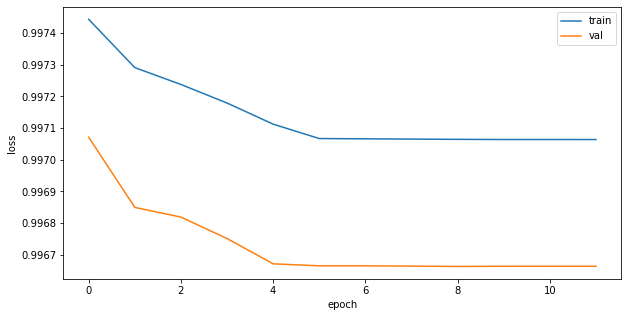

 28%|██▊       | 5/18 [00:32<01:23,  6.44s/it]

SystemError: <built-in function ReadImage> returned a result with an error set

In [50]:
torch.cuda.empty_cache()

# if experiment:
#     experiment.set_name("Pirogov seg to FCD, combined ellipse mask, dice loss")

training_params =  {
    'num_epochs': 30, 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ratio' : None,
    #'experiment': experiment,
    'weights_stem':'pirogov_seg_to_fcd_combined_ellipse_masks_dice_loss',
    'verbose':True,
    'save_epoch':1,
    'loss_type': 'dice',
    'task': 'T1_to_fcd'
}

train(**training_params)

In [51]:
model, optimizer, scheduler = get_model_and_optimizer(device, 
                                                      num_encoding_blocks = 2, 
                                                      out_channels_first_layer = 1)
model.load_state_dict(torch.load('weights/pirogov_seg_to_fcd_combined_ellipse_masks_dice_loss_epoch_5.pth'))

<All keys matched successfully>

In [52]:
model.eval()

dice_scores = []
iou_scores = []
average_distances_gt_to_pred = []
average_distances_pred_to_gt = []

for batch in tqdm(validation_loader):
    inputs, targets = prepare_batch(batch, device, task = 'T1_to_fcd')
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        prediction = probabilities.argmin(dim = 1)[0]
        ground_true  = targets[0,0,:]
        
    dice_scores.append((get_dice_score(targets, probabilities)*torch.tensor([1, 0]).float().to(device)).sum().cpu().detach().numpy())
    iou_scores.append(get_iou_score(prediction.cpu().detach().numpy(), ground_true.cpu().detach().numpy()))
    
    average_distance_gt_to_pred, average_distance_pred_to_gt = compute_average_surface_distance(
        compute_surface_distances(
        ground_true.cpu().numpy().astype(np.uint8),
        prediction.cpu().numpy(), 
        spacing_mm=(1,1,1)
        )
    )
    
    average_distances_gt_to_pred.append(average_distance_gt_to_pred)
    average_distances_pred_to_gt.append(average_distance_pred_to_gt)
    
print('Mean dice score = ', np.mean(dice_scores))
print('Mean IoU score = ', np.mean(iou_scores))
print('Mean average distance gt to prediction = ', np.mean([x for x in average_distances_gt_to_pred if  np.isnan(x)== False]))
print('Mean average distance prediction to gt = ', np.mean([x for x in average_distances_pred_to_gt if x != np.inf]))


100%|██████████| 8/8 [02:49<00:00, 21.15s/it]


Mean dice score =  0.0033283665493760504
Mean IoU score =  0.0014749688505405042
Mean average distance gt to prediction =  29.656709430740378
Mean average distance prediction to gt =  202.4426427261514


In [53]:
model.eval()

batch = next(iter(validation_loader))
inputs, targets = prepare_batch(batch, device, task = 'T1_to_fcd')
with torch.no_grad():
    logits = forward(model, inputs)
    probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
pred = probabilities.argmin(dim = 1)[0]
seg  = targets[0,0,:]

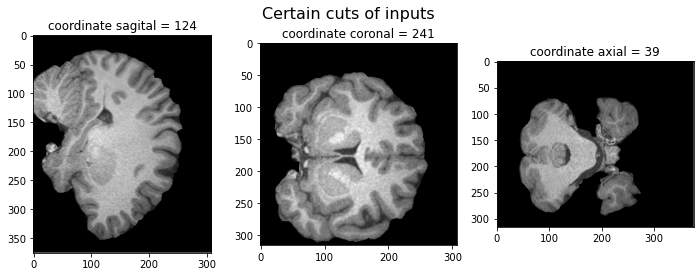

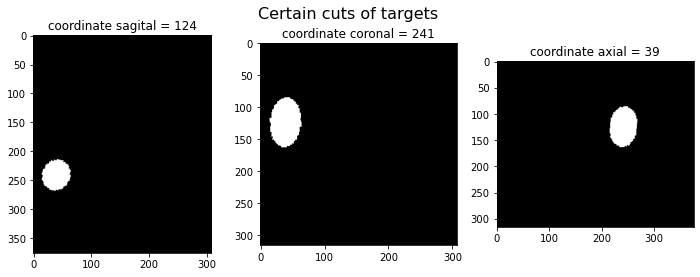

In [54]:
plot_certain_cuts(inputs[0,0,:].cpu().detach().numpy(), 
                  get_center_coord_of_bb(targets[0,0,:].cpu().detach().numpy()), 'inputs')
plot_certain_cuts(targets[0,0,:].cpu().detach().numpy() 
                  , get_center_coord_of_bb(targets[0,0,:].cpu().detach().numpy()), 'targets')

In [57]:
from ipywidgets import IntSlider, interact

def plot_gt_pred(gt_slice, pred_slice, cmap = 'gray'):


    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize = (10, 10))
    
    ax0.imshow(gt_slice, cmap=cmap)
    ax0.set_title('Ground true')
    ax0.grid(True)

    ax1.imshow(pred_slice, cmap=cmap)
    ax1.set_title('Prediction')
    ax1.grid(True)

    plt.show()
    
def vary_coordinate(sagital, coronal, axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_gt_pred(gt[sagital,:,:], prediction[sagital,:,:])
    if axis == 'coronal':
        plot_gt_pred(gt[:,coronal ,:], prediction[:,coronal ,:] )
    if axis == 'axial':
        plot_gt_pred(gt[:,:, axial], prediction[:,:, axial])
    
def slider(gt, pred):
    
    sld_sagital = IntSlider(min=0, max=prediction.shape[0]-1, step=1, continuous_update=True)
    sld_coronal = IntSlider(min=0, max=prediction.shape[1]-1, step=1, continuous_update=True)
    sld_axial   = IntSlider(min=0, max=prediction.shape[2]-1, step=1, continuous_update=True)
    
    interact(vary_coordinate, 
         sagital = sld_sagital,
         coronal = sld_coronal,
         axial = sld_axial,
         axis = 'axial');

In [61]:
prediction = 1 - pred.cpu().detach().numpy()
gt = seg.cpu().detach().numpy()

sld_sagital = IntSlider(min=0, max=pred.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=pred.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=pred.shape[2]-1, step=1, continuous_update=True)
    
interact(vary_coordinate, 
     sagital = sld_sagital,
     coronal = sld_coronal,
     axial = sld_axial,
     axis = 'axial');

interactive(children=(IntSlider(value=0, description='sagital', max=315), IntSlider(value=0, description='coro…